In [356]:
import numpy as np
import pandas as pd
import sqlite3
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [357]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
print(type(movie_budgets))

with zipfile.ZipFile('zippedData/im.db.zip', 'r') as z:
    z.printdir()
    imdb_data = z.extractall()

# open SQL link to im.db.zip

conn = sqlite3.connect('im.db')

<class 'pandas.core.frame.DataFrame'>
File Name                                             Modified             Size
im.db                                          2021-12-20 16:31:38    169443328


Clean titles

In [358]:
movie_gross['title'] = movie_gross['title'].str.strip().str.replace('[^\w\s]', '')
movies['original_title'] = movies['original_title'].str.strip().str.replace('[^\w\s]', '')
movie_budgets['movie'] = movie_budgets['movie'].str.strip().str.replace('[^\w\s]', '')

In [359]:
movie_gross['title'] = movie_gross['title'].str.upper()
movies['original_title'] = movies['original_title'].str.upper()
movie_budgets['movie'] = movie_budgets['movie'].str.upper()

In [360]:
movie_gross

,title,studio,domestic_gross,foreign_gross,year
0,TOY STORY 3,BV,415000000.0,652000000,2010
1,ALICE IN WONDERLAND 2010,BV,334200000.0,691300000,2010
2,HARRY POTTER AND THE DEATHLY HALLOWS PART 1,WB,296000000.0,664300000,2010
3,INCEPTION,WB,292600000.0,535700000,2010
4,SHREK FOREVER AFTER,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,THE QUAKE,Magn.,6200.0,NaN,2018
3383,EDWARD II 2018 RERELEASE,FM,4800.0,NaN,2018
3384,EL PACTO,Sony,2500.0,NaN,2018
3385,THE SWAN,Synergetic,2400.0,NaN,2018


In [361]:
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

In [362]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [363]:
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")
movie_info['box_office']

0              NaN
1         600000.0
2              NaN
3              NaN
4              NaN
           ...    
1555    33886034.0
1556           NaN
1557           NaN
1558           NaN
1559           NaN
Name: box_office, Length: 1560, dtype: float64

In [364]:
for i in movie_info['currency']:
    if i is not None:
        i = 1
    else:
        i = 0
movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [365]:
movie_info.iloc[[1558]]

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [366]:
movie_info['theater_date']

0        Oct 9, 1971
1       Aug 17, 2012
2       Sep 13, 1996
3        Dec 9, 1994
4                NaN
            ...     
1555    Aug 18, 2006
1556    Jul 23, 1993
1557     Jan 1, 1962
1558     Apr 1, 1993
1559    Sep 27, 2001
Name: theater_date, Length: 1560, dtype: object

In [367]:
movie_info['dvd_date']

0       Sep 25, 2001
1        Jan 1, 2013
2       Apr 18, 2000
3       Aug 27, 1997
4                NaN
            ...     
1555     Jan 2, 2007
1556    Apr 17, 2001
1557    May 11, 2004
1558    Jan 29, 2002
1559    Feb 11, 2003
Name: dvd_date, Length: 1560, dtype: object

In [368]:
movie_info['runtime']

0       104 minutes
1       108 minutes
2       116 minutes
3       128 minutes
4       200 minutes
           ...     
1555    106 minutes
1556     88 minutes
1557    111 minutes
1558    101 minutes
1559     94 minutes
Name: runtime, Length: 1560, dtype: object

In [369]:
movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")

In [370]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [371]:
reviews['rating']
# reviews['rating'] = reviews['rating'].str.replace('/5','')
#reviews['rating']  = reviews['rating'].astype("float64")
reviews.loc[reviews['rating'] != 'C']

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [372]:
reviews['fresh'] = reviews['fresh'].str.replace('fresh','1')
reviews['fresh'] = reviews['fresh'].str.replace('rotten','0')
reviews['fresh']  = reviews['fresh'].astype("float64")


In [373]:
reviews['fresh'].value_counts()

1.0    33035
0.0    21397
Name: fresh, dtype: int64

In [374]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [375]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [376]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [377]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [378]:
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')

movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

In [379]:
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')

movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")

In [380]:
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")

In [381]:
movieJoinGross = pd.DataFrame.merge(movies, movie_gross, on = 'title')
movieJoinGross

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year
0,81,"[28, 12, 35, 80, 53]",39514,en,RED,12.082,2010-10-14,RED,6.6,4162,Sum.,90400000.0,108600000.0,2010
1,2794,"[12, 18, 28, 36, 10752]",76349,zh,辛亥革命,7.437,2011-10-07,1911,5.5,62,Vari.,136000.0,NaN,2011
2,2807,"[878, 18]",77561,es,EVA,7.321,2011-11-11,EVA,6.5,199,Wein.,16700.0,NaN,2015
3,5453,"[18, 10749]",89455,en,360,7.276,2012-08-03,360,5.8,144,Magn.,100000.0,1600000.0,2012
4,5483,"[27, 53]",89691,en,ATM,6.984,2012-04-06,ATM,5.1,291,IFC,3000.0,NaN,2012
5,7928,"[28, 35, 80, 53]",146216,en,RED 2,14.994,2013-07-19,RED 2,6.5,2368,LG/S,53300000.0,94800000.0,2013
6,11305,"[35, 18]",297222,hi,पक,7.993,2014-12-19,PK,7.8,438,UTV,10600000.0,89800000.0,2014


In [382]:
movie_budgets.rename(columns = {'movie':'title'}, inplace = True)
movieJoinGrossJoinBudget = pd.DataFrame.merge(movieJoinGross, movie_budgets, on = 'title')
movieJoinGrossJoinBudget

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,studio,domestic_gross_x,foreign_gross,year,id_y,release_date_y,production_budget,domestic_gross_y,worldwide_gross
0,81,"[28, 12, 35, 80, 53]",39514,en,RED,12.082,2010-10-14,RED,6.6,4162,Sum.,90400000.0,108600000.0,2010,63,"Oct 15, 2010",60000000.0,90380162.0,196439693.0
1,7928,"[28, 35, 80, 53]",146216,en,RED 2,14.994,2013-07-19,RED 2,6.5,2368,LG/S,53300000.0,94800000.0,2013,28,"Jul 19, 2013",84000000.0,53262560.0,141507355.0


In [383]:
movieJoinGrossJoinBudget.isna().sum()

Unnamed: 0           0
genre_ids            0
id_x                 0
original_language    0
original_title       0
popularity           0
release_date_x       0
title                0
vote_average         0
vote_count           0
studio               0
domestic_gross_x     0
foreign_gross        0
year                 0
id_y                 0
release_date_y       0
production_budget    0
domestic_gross_y     0
worldwide_gross      0
dtype: int64

In [384]:
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('id_x', axis= 1)
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('id_y', axis =1)
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('release_date_y', axis= 1)
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('domestic_gross_x', axis =1)
movieJoinGrossJoinBudget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2 non-null      int64  
 1   genre_ids          2 non-null      object 
 2   original_language  2 non-null      object 
 3   original_title     2 non-null      object 
 4   popularity         2 non-null      float64
 5   release_date_x     2 non-null      object 
 6   title              2 non-null      object 
 7   vote_average       2 non-null      float64
 8   vote_count         2 non-null      int64  
 9   studio             2 non-null      object 
 10  foreign_gross      2 non-null      float64
 11  year               2 non-null      int64  
 12  production_budget  2 non-null      float64
 13  domestic_gross_y   2 non-null      float64
 14  worldwide_gross    2 non-null      float64
dtypes: float64(6), int64(3), object(6)
memory usage: 256.0+ bytes


In [385]:
movieJoinGrossJoinBudget.isna().sum()

Unnamed: 0           0
genre_ids            0
original_language    0
original_title       0
popularity           0
release_date_x       0
title                0
vote_average         0
vote_count           0
studio               0
foreign_gross        0
year                 0
production_budget    0
domestic_gross_y     0
worldwide_gross      0
dtype: int64

In [386]:
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.dropna()

In [387]:
movieJoinGrossJoinBudget.isna().sum()

Unnamed: 0           0
genre_ids            0
original_language    0
original_title       0
popularity           0
release_date_x       0
title                0
vote_average         0
vote_count           0
studio               0
foreign_gross        0
year                 0
production_budget    0
domestic_gross_y     0
worldwide_gross      0
dtype: int64

In [388]:
movieJoinGrossJoinBudget

,Unnamed: 0,genre_ids,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,studio,foreign_gross,year,production_budget,domestic_gross_y,worldwide_gross
0,81,"[28, 12, 35, 80, 53]",en,RED,12.082,2010-10-14,RED,6.6,4162,Sum.,108600000.0,2010,60000000.0,90380162.0,196439693.0
1,7928,"[28, 35, 80, 53]",en,RED 2,14.994,2013-07-19,RED 2,6.5,2368,LG/S,94800000.0,2013,84000000.0,53262560.0,141507355.0


In [389]:
holder = movieJoinGrossJoinBudget['genre_ids'].str.split(',', n=7, expand=True)

In [390]:
holder2 = movieJoinGrossJoinBudget

In [391]:
holder3 = pd.concat([holder, holder2])

In [392]:
holder3

,0,1,2,3,4,Unnamed: 0,domestic_gross_y,foreign_gross,genre_ids,original_language,original_title,popularity,production_budget,release_date_x,studio,title,vote_average,vote_count,worldwide_gross,year
0,[28,12,35,80,53],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[28,35,80,53],None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,81.0,90380162.0,108600000.0,"[28, 12, 35, 80, 53]",en,RED,12.082,60000000.0,2010-10-14,Sum.,RED,6.6,4162.0,196439693.0,2010.0
1,NaN,NaN,NaN,NaN,NaN,7928.0,53262560.0,94800000.0,"[28, 35, 80, 53]",en,RED 2,14.994,84000000.0,2013-07-19,LG/S,RED 2,6.5,2368.0,141507355.0,2013.0


In [393]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   title              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


Comparing budget and profit 

In [394]:
movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

In [395]:
movie_budgets.sort_values(['profit'], ascending=False)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",AVATAR,425000000.0,760507625.0,2.776345e+09,2.351345e+09
42,43,"Dec 19, 1997",TITANIC,200000000.0,659363944.0,2.208208e+09,2.008208e+09
6,7,"Apr 27, 2018",AVENGERS INFINITY WAR,300000000.0,678815482.0,2.048134e+09,1.748134e+09
5,6,"Dec 18, 2015",STAR WARS EP VII THE FORCE AWAKENS,306000000.0,936662225.0,2.053311e+09,1.747311e+09
33,34,"Jun 12, 2015",JURASSIC WORLD,215000000.0,652270625.0,1.648855e+09,1.433855e+09
...,...,...,...,...,...,...,...
352,53,"Apr 27, 2001",TOWN COUNTRY,105000000.0,6712451.0,1.036477e+07,-9.463523e+07
341,42,"Jun 14, 2019",MEN IN BLACK INTERNATIONAL,110000000.0,3100000.0,3.100000e+06,-1.069000e+08
193,94,"Mar 11, 2011",MARS NEEDS MOMS,150000000.0,21392758.0,3.954976e+07,-1.104502e+08
194,95,"Dec 31, 2020",MOONFALL,150000000.0,0.0,0.000000e+00,-1.500000e+08


C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='production_budget', ylabel='profit'>

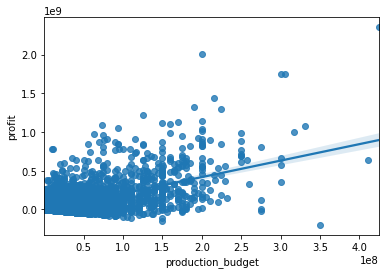

In [396]:
sns.regplot(movie_budgets['production_budget'], movie_budgets["profit"])

Comparing rating to directors

In [397]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [398]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1560 non-null   int64  
 1   synopsis      1498 non-null   object 
 2   rating        1557 non-null   object 
 3   genre         1552 non-null   object 
 4   director      1361 non-null   object 
 5   writer        1111 non-null   object 
 6   theater_date  1201 non-null   object 
 7   dvd_date      1201 non-null   object 
 8   currency      340 non-null    object 
 9   box_office    340 non-null    float64
 10  runtime       1530 non-null   float64
 11  studio        494 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 146.4+ KB


In [399]:
movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,HARRY POTTER AND THE DEATHLY HALLOWS PART 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,HOW TO TRAIN YOUR DRAGON,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,IRON MAN 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,TOY STORY,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,INCEPTION,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,LABORATORY CONDITIONS,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84XXX_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,THE LAST ONE,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,TRAILER MADE,0.600,2018-06-22,Trailer Made,0.0,1


In [400]:
movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106.0,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88.0,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111.0,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101.0,NaN


In [401]:
reviews

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,1.0,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,0.0,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,1.0,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,1.0,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,1.0,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,1.0,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,0.0,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,0.0,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,0.0,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [402]:
pd.read_sql("""
    SELECT name
      FROM 'sqlite_master'
     WHERE type = 'table'
  ;
""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [403]:
pd.read_sql("""
    SELECT 
    persons.primary_name
    FROM persons
  ;
""", conn)

,primary_name
0,Mary Ellen Bauder
1,Joseph Bauer
2,Bruce Baum
3,Axel Baumann
4,Pete Baxter
...,...
606643,Susan Grobes
606644,Joo Yeon So
606645,Madeline Smith
606646,Michelle Modigliani


In [404]:
pd.read_sql("""
    SELECT 
    *
    FROM principals
  ;
""", conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [405]:
pd.read_sql("""
    SELECT 
    movie_ratings.numvotes, movie_basics.original_title
    FROM movie_ratings
    JOIN movie_basics
        USING(movie_id)
  ;
""", conn)

,numvotes,original_title
0,31,Laiye Je Yaarian
1,559,Borderless
2,20,Just Inès
3,50352,The Legend of Hercules
4,21,Até Onde?
...,...,...
73851,25,Caisa
73852,24,Code Geass: Lelouch of the Rebellion Episode III
73853,14,Sisters
73854,5,The Projectionist


In [406]:
pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

,director,title,AVG_Movie_rating
0,Tim Gagliardo,Wheels,9.3
1,Murat Dündar,CM101MMXI Fundamentals,9.2
2,Dipendra K. Khanal,Pashupati Prasad,9.0
3,Tomasz Sekielski,Tylko nie mów nikomu,8.9
4,Hemanth M. Rao,Godhi Banna Sadharana Mykattu,8.9
...,...,...,...
2596,Erdi Dikmen,Sihirbazlik Okulunda Bir Türk,2.2
2597,Lawrence Kasanoff,Foodfight!,1.9
2598,James Nguyen,Birdemic: Shock and Terror,1.8
2599,Cris D'Amato,É Fada!,1.7


In [407]:
movie_ratings = pd.read_sql("""
    SELECT 
    *
    FROM movie_ratings
  ;
""", conn)

In [408]:
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [409]:
directorRatings = pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

movies need atleast 1000 votes and directors need to have directed atleast 2 movies to make this list

In [410]:
directorRatings

,director,title,AVG_Movie_rating
0,Tim Gagliardo,Wheels,9.3
1,Murat Dündar,CM101MMXI Fundamentals,9.2
2,Dipendra K. Khanal,Pashupati Prasad,9.0
3,Tomasz Sekielski,Tylko nie mów nikomu,8.9
4,Hemanth M. Rao,Godhi Banna Sadharana Mykattu,8.9
...,...,...,...
2596,Erdi Dikmen,Sihirbazlik Okulunda Bir Türk,2.2
2597,Lawrence Kasanoff,Foodfight!,1.9
2598,James Nguyen,Birdemic: Shock and Terror,1.8
2599,Cris D'Amato,É Fada!,1.7


In [411]:
budgetJoinDirector = pd.DataFrame.merge(movie_budgets, directorRatings, on = 'title')

In [412]:
budgetJoinDirector=budgetJoinDirector.drop('id', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('release_date', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('title', axis =1)



In [413]:
budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

,production_budget,domestic_gross,worldwide_gross,profit,AVG_Movie_rating
director,,,,,
Brian Helgeland,31000000.0,95020213.0,97470701.0,66470701.0,7.5
Aishwarya Dhanush,7200000.0,59774.0,295492.0,-6904508.0,7.2
Lisa Azuelos,11000000.0,0.0,10431506.0,-568494.0,4.4


In [414]:
grouped = budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AVG_Movie_rating', ylabel='profit'>

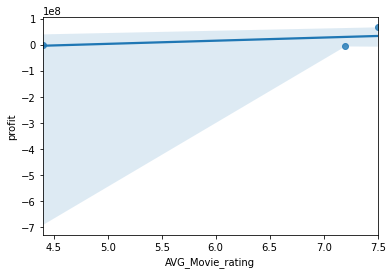

In [415]:
sns.regplot(grouped['AVG_Movie_rating'], grouped["profit"])

C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='profit', ylabel='AVG_Movie_rating'>

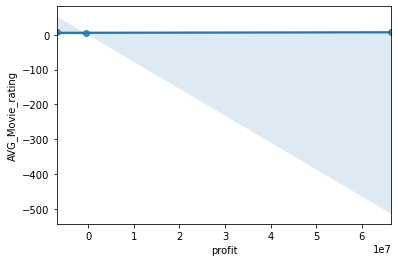

In [416]:
sns.regplot(grouped["profit"], grouped['AVG_Movie_rating'])

In [417]:
 pd.read_sql("""
    SELECT 
    *
    FROM principals
  ;
""", conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [418]:
 pd.read_sql("""
    SELECT 
    *
    FROM movie_akas
    WHERE attributes != 'None'
  ;
""", conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
1,tt0369610,21,Jurassic World 3D,US,None,None,3-D version,0.0
2,tt0369610,22,Jurassic World 3D,DE,None,None,3-D version,0.0
3,tt0369610,23,Jurassic World 3D,XWW,None,None,3-D version,0.0
4,tt0369610,2,Ebb Tide,US,None,None,fake working title,0.0
...,...,...,...,...,...,...,...,...
14920,tt8899108,2,Volviendo a casa,UY,None,None,original subtitled version,0.0
14921,tt8997034,1,Little Germanics,XWW,en,None,informal literal English title,0.0
14922,tt9190740,1,Car Ribna Wali,IN,ur,None,alternative transliteration,0.0
14923,tt9447768,1,The Town School,LK,None,None,alternative transliteration,0.0


run time vs profit and rating

In [419]:
runtimeDF = pd.read_sql("""
    SELECT 
    movie_basics.original_title AS title, movie_basics.runtime_minutes, movie_ratings.averagerating
    FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
    WHERE movie_ratings.numvotes >= 1000
    ORDER BY averagerating DESC
  ;
""", conn)

In [420]:
runtimeDF['title'] = runtimeDF['title'].str.strip().str.replace('[^\w\s]', '')
runtimeDF['title'] = runtimeDF['title'].str.upper()
runtimeJOINbuget = pd.DataFrame.merge(movie_budgets, runtimeDF, on = 'title')

In [421]:
runtimeJOINbuget

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit,runtime_minutes,averagerating
0,2,"May 20, 2011",PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,241063875.0,1.045664e+09,6.350639e+08,136.0,6.6
1,3,"Jun 7, 2019",DARK PHOENIX,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,113.0,6.0
2,4,"May 1, 2015",AVENGERS AGE OF ULTRON,330600000.0,459005868.0,1.403014e+09,1.072414e+09,141.0,7.3
3,7,"Apr 27, 2018",AVENGERS INFINITY WAR,300000000.0,678815482.0,2.048134e+09,1.748134e+09,149.0,8.5
4,9,"Nov 17, 2017",JUSTICE LEAGUE,300000000.0,229024295.0,6.559452e+08,3.559452e+08,120.0,6.5
...,...,...,...,...,...,...,...,...,...
1819,18,"Nov 12, 2010",TINY FURNITURE,50000.0,391674.0,4.241490e+05,3.741490e+05,98.0,6.2
1820,38,"Mar 18, 2016",KRISHA,30000.0,144822.0,1.448220e+05,1.148220e+05,83.0,7.2
1821,49,"Sep 1, 2015",EXETER,25000.0,0.0,4.897920e+05,4.647920e+05,91.0,4.5
1822,56,"Jan 4, 2013",ALL SUPERHEROES MUST DIE,20000.0,0.0,0.000000e+00,-2.000000e+04,78.0,4.0


In [422]:
runtimeJOINbuget=runtimeJOINbuget.drop('id', axis =1)
runtimeJOINbuget=runtimeJOINbuget.drop('release_date', axis =1)
runtimeJOINbuget=runtimeJOINbuget.drop('domestic_gross', axis =1)

In [423]:
runtimeJOINbuget

,title,production_budget,worldwide_gross,profit,runtime_minutes,averagerating
0,PIRATES OF THE CARIBBEAN ON STRANGER TIDES,410600000.0,1.045664e+09,6.350639e+08,136.0,6.6
1,DARK PHOENIX,350000000.0,1.497624e+08,-2.002376e+08,113.0,6.0
2,AVENGERS AGE OF ULTRON,330600000.0,1.403014e+09,1.072414e+09,141.0,7.3
3,AVENGERS INFINITY WAR,300000000.0,2.048134e+09,1.748134e+09,149.0,8.5
4,JUSTICE LEAGUE,300000000.0,6.559452e+08,3.559452e+08,120.0,6.5
...,...,...,...,...,...,...
1819,TINY FURNITURE,50000.0,4.241490e+05,3.741490e+05,98.0,6.2
1820,KRISHA,30000.0,1.448220e+05,1.148220e+05,83.0,7.2
1821,EXETER,25000.0,4.897920e+05,4.647920e+05,91.0,4.5
1822,ALL SUPERHEROES MUST DIE,20000.0,0.000000e+00,-2.000000e+04,78.0,4.0


<AxesSubplot:xlabel='runtime_minutes', ylabel='profit'>

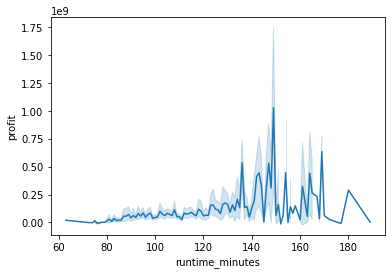

In [424]:
sns.lineplot(data = runtimeJOINbuget, x = 'runtime_minutes', y = 'profit')

<AxesSubplot:xlabel='runtime_minutes', ylabel='averagerating'>

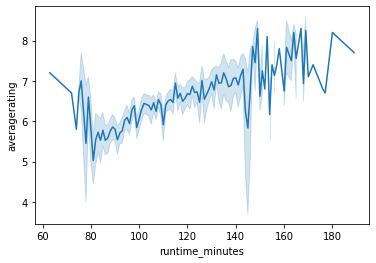

In [425]:
sns.lineplot(data = runtimeJOINbuget, x = 'runtime_minutes', y = 'averagerating')

<BarContainer object of 1824 artists>

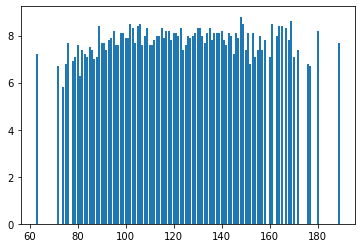

In [426]:
plt.bar(runtimeJOINbuget["runtime_minutes"],runtimeJOINbuget["averagerating"])

<BarContainer object of 1824 artists>

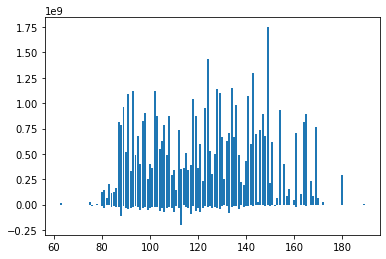

In [427]:
plt.bar(runtimeJOINbuget["runtime_minutes"],runtimeJOINbuget["profit"])

Inflation rate calcualtion

15% increase in movie ticket prices over the past 10 years


In [428]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   title              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
 6   profit             5782 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 316.3+ KB


In [429]:
movie_budgets.rename(columns = {'movie' : 'title'}, inplace = True)
print(type(movie_gross))
print(type(movie_budgets))
grossJoinBudget = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [430]:
grossJoinBudget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1306
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1307 non-null   object 
 1   studio             1306 non-null   object 
 2   domestic_gross_x   1305 non-null   float64
 3   foreign_gross      1136 non-null   float64
 4   year               1307 non-null   int64  
 5   id                 1307 non-null   int64  
 6   release_date       1307 non-null   object 
 7   production_budget  1307 non-null   float64
 8   domestic_gross_y   1307 non-null   float64
 9   worldwide_gross    1307 non-null   float64
 10  profit             1307 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 122.5+ KB


In [431]:
i = 0
for row in grossJoinBudget.itertuples(index = False):
    if row[4] == 2010:
        grossJoinBudget.iat[i,7] = row[7] * ((8*.0151) + 1)
       
    if row[4] == 2011:
        grossJoinBudget.iat[i,7] = row[7] * ((7*.0151) + 1)
        
    if row[4] == 2012:
        grossJoinBudget.iat[i,7] = row[7] * ((6*.0151) + 1)
       
    if row[4] == 2013:
        grossJoinBudget.iat[i,7] = row[7] * ((5*.0151) + 1)
        
    if row[4] == 2014:
        grossJoinBudget.iat[i,7] = row[7] * ((4*.0151) + 1)
        
    if row[4] == 2015:
        grossJoinBudget.iat[i,7] = row[7] * ((3*.0151) + 1)
        
    if row[4] == 2016:
        grossJoinBudget.iat[i,7] = row[7] * ((2*.0151) + 1)
        
    if row[4] == 2017:
        grossJoinBudget.iat[i,7] = row[7] * ((1*.0151) + 1)
       
    i +=1
    

In [432]:
i = 0
for row in grossJoinBudget.itertuples(index = False):
    if row[4] == 2010:
        grossJoinBudget.iat[i,9] = row[9] * ((8*.0451) + 1)
       
    if row[4] == 2011:
        grossJoinBudget.iat[i,9] = row[9] * ((7*.0451) + 1)
        
    if row[4] == 2012:
        grossJoinBudget.iat[i,9] = row[9] * ((6*.0451) + 1)
       
    if row[4] == 2013:
        grossJoinBudget.iat[i,9] = row[9] * ((5*.0451) + 1)
        
    if row[4] == 2014:
        grossJoinBudget.iat[i,9] = row[9] * ((4*.0451) + 1)
        
    if row[4] == 2015:
        grossJoinBudget.iat[i,9] = row[9] * ((3*.0451) + 1)
        
    if row[4] == 2016:
        grossJoinBudget.iat[i,9] = row[9] * ((2*.0451) + 1)
        
    if row[4] == 2017:
        grossJoinBudget.iat[i,9] = row[9] * ((1*.0451) + 1)
       
    i +=1

In [433]:
grossJoinBudget

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,production_budget,domestic_gross_y,worldwide_gross,profit
0,TOY STORY 3,BV,415000000.0,652000000.0,2010,47,"Jun 18, 2010",224160000.0,415004880.0,1.454531e+09,868879522.0
1,INCEPTION,WB,292600000.0,535700000.0,2010,38,"Jul 16, 2010",179328000.0,292576195.0,1.136982e+09,675524642.0
2,SHREK FOREVER AFTER,P/DW,238700000.0,513900000.0,2010,27,"May 21, 2010",184932000.0,238736787.0,1.029098e+09,591244673.0
3,THE TWILIGHT SAGA ECLIPSE,Sum.,300500000.0,398000000.0,2010,53,"Jun 30, 2010",76214400.0,300531751.0,9.608647e+08,638102828.0
4,IRON MAN 2,Par.,312400000.0,311500000.0,2010,15,"May 7, 2010",190536000.0,312433331.0,8.452696e+08,451156389.0
...,...,...,...,...,...,...,...,...,...,...,...
1302,BEN IS BACK,RAtt.,3700000.0,NaN,2018,95,"Dec 7, 2018",13000000.0,3703182.0,9.633111e+06,-3366889.0
1303,BILAL A NEW BREED OF HERO,VE,491000.0,1700000.0,2018,100,"Feb 2, 2018",30000000.0,490973.0,6.485990e+05,-29351401.0
1304,MANDY,RLJ,1200000.0,NaN,2018,71,"Sep 14, 2018",6000000.0,1214525.0,1.427656e+06,-4572344.0
1305,LEAN ON PETE,A24,1200000.0,NaN,2018,13,"Apr 6, 2018",8000000.0,1163056.0,2.455027e+06,-5544973.0


In [434]:
grossJoinBudget.groupby('year').mean()

,domestic_gross_x,foreign_gross,id,production_budget,domestic_gross_y,worldwide_gross,profit
year,,,,,,,
2010,4.627240e+07,5.937500e+07,47.031250,4.547534e+07,4.608727e+07,1.424448e+08,6.410324e+07
2011,4.872449e+07,8.428872e+07,52.338983,4.737253e+07,4.888044e+07,1.580048e+08,7.724788e+07
2012,5.872797e+07,9.928689e+07,51.555556,5.017769e+07,5.863597e+07,1.857945e+08,1.002165e+08
2013,6.638920e+07,1.062007e+08,49.572414,5.581474e+07,6.559241e+07,1.959376e+08,1.079873e+08
2014,6.347044e+07,1.206046e+08,48.543478,4.758666e+07,6.320583e+07,1.902330e+08,1.162836e+08
2015,5.938219e+07,9.398790e+07,50.033784,4.783307e+07,6.014758e+07,1.755992e+08,1.089119e+08
2016,6.494432e+07,1.223076e+08,50.696552,5.081870e+07,6.519118e+07,1.772641e+08,1.132688e+08
2017,7.346111e+07,1.390638e+08,53.585586,5.767323e+07,7.342812e+07,2.108238e+08,1.449106e+08
2018,8.470635e+07,1.281473e+08,56.295918,5.523571e+07,8.476585e+07,2.144115e+08,1.591758e+08


In [435]:
grossJoinBudget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1306
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1307 non-null   object 
 1   studio             1306 non-null   object 
 2   domestic_gross_x   1305 non-null   float64
 3   foreign_gross      1136 non-null   float64
 4   year               1307 non-null   int64  
 5   id                 1307 non-null   int64  
 6   release_date       1307 non-null   object 
 7   production_budget  1307 non-null   float64
 8   domestic_gross_y   1307 non-null   float64
 9   worldwide_gross    1307 non-null   float64
 10  profit             1307 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 122.5+ KB


In [436]:
x = 15/10
x

1.5

In [99]:
x = 7.96

for i in range(10):
    x = x * 1.0145
    print(i)
x

0
1
2
3
4
5
6
7
8
9


9.192498791189315

In [104]:
x = 7.96
x = x * ((10*.0151)+1)
x

9.16196

In [89]:
x = 55235710/40574000
x

1.3613572731305763

In [94]:
x = 36/8
x

4.5

In [96]:
x = 40574000

for i in range(8):
    x = x * 1.04
    print(i)
x

0
1
2
3
4
5
6
7


55528320.65114358

In [107]:
x = 40574000
x = x * ((8*.0451)+1)
x

55213099.2

In [127]:
inflationrate = grossJoinBudget.groupby('year').mean()
inflationrate

,domestic_gross_x,foreign_gross,id,production_budget,domestic_gross_y,worldwide_gross,profit
year,,,,,,,
2010,4.627240e+07,5.937500e+07,47.031250,4.057400e+07,4.608727e+07,1.046772e+08,6.410324e+07
2011,4.872449e+07,8.428872e+07,52.338983,4.284393e+07,4.888044e+07,1.200918e+08,7.724788e+07
2012,5.872797e+07,9.928689e+07,51.555556,4.600925e+07,5.863597e+07,1.462258e+08,1.002165e+08
2013,6.638920e+07,1.062007e+08,49.572414,5.189655e+07,6.559241e+07,1.598838e+08,1.079873e+08
2014,6.347044e+07,1.206046e+08,48.543478,4.487614e+07,6.320583e+07,1.611598e+08,1.162836e+08
2015,5.938219e+07,9.398790e+07,50.033784,4.576014e+07,6.014758e+07,1.546720e+08,1.089119e+08
2016,6.494432e+07,1.223076e+08,50.696552,4.932897e+07,6.519118e+07,1.625977e+08,1.132688e+08
2017,7.346111e+07,1.390638e+08,53.585586,5.681532e+07,7.342812e+07,2.017259e+08,1.449106e+08
2018,8.470635e+07,1.281473e+08,56.295918,5.523571e+07,8.476585e+07,2.144115e+08,1.591758e+08


In [137]:
inflationrate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 2010 to 2018
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   domestic_gross_x        9 non-null      float64
 1   foreign_gross           9 non-null      float64
 2   id                      9 non-null      float64
 3   production_budget       9 non-null      float64
 4   domestic_gross_y        9 non-null      float64
 5   worldwide_gross         9 non-null      float64
 6   profit                  9 non-null      float64
 7   (0, production_budget)  9 non-null      float64
 8   (1, production_budget)  9 non-null      float64
 9   (2, production_budget)  9 non-null      float64
 10  (3, production_budget)  9 non-null      float64
 11  (4, production_budget)  9 non-null      float64
 12  (5, production_budget)  9 non-null      float64
 13  (6, production_budget)  9 non-null      float64
 14  (7, production_budget)  9 non-null      

In [140]:
i = 8
x = 8
year = 0
for value in inflationrate['production_budget']:
    value = value * ((i*.0151) + 1)
    inflationrate.iloc[year],['production_budget'] = value
    i -=1
    year +=1
    print(value)
year = 2010
for value in inflationrate['worldwide_gross']:
    value = value * ((x*.0451) + 1)
    inflationrate.loc[year.str()],['worldwide_gross'] = value
    x-=1
    year +=1
    print(value)
inflationrate

SyntaxError: cannot assign to literal (<ipython-input-140-28ed6e148545>, line 6)

In [121]:
inflationrate.columns

Index(['domestic_gross_x', 'foreign_gross', 'id', 'production_budget',
       'domestic_gross_y', 'worldwide_gross', 'profit'],
      dtype='object')

In [122]:
inflationrate['production_budget']

year
2010    4.057400e+07
2011    4.284393e+07
2012    4.600925e+07
2013    5.189655e+07
2014    4.487614e+07
2015    4.576014e+07
2016    4.932897e+07
2017    5.681532e+07
2018    5.523571e+07
Name: production_budget, dtype: float64

In [ ]:
for value in range(8):